# Cuadratura Gaussiana

In [811]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

In [812]:
x = sym.Symbol('x',real=True)
y = sym.Symbol('y',real=True)

Seguimos con el problema de integrar una función $f(x)$ en cierto intervalo \[a,b\] mediante su cuadratura. Es decir, realizando una suma con pesos de la función en ciertos nodos

$$\begin{align*}
\int_a^b f(x) dx = \sum_{k=0}^{n-1} c_k f(x_k)
\end{align*}
$$

## Gauss-Legendre

La aproximación de Gauss-Legendre consiste en encontrar los $k$ nodos y pesos tal que 
    $$ \begin{align*}
        \int_{-1}^1 f(x) dx &= \sum_{k=0}^{n-1} c_k f(x_k) 
    \end{align*}$$
    Se puede demostrar que para $n$ nodos, estos están dados por los ceros de los *Polinomios de Legendre*, definidos mediante la fórmula de Rodrigues como

$$ \begin{align*}
P_n(x) &= \frac{1}{2^n n!} \frac{d^n}{dx^n}(x^2-1)^n
\end{align*} $$

A partir de esto, se puede crear una función en Python que retorne el $n$-ésimo polinomio de Legendre.

In [813]:
def GetLegendre(n,x,y):
    
    y = (x**2 - 1)**n
    
    poly = sym.diff( y,x,n )/(2**n*np.math.factorial(n))
    
    return poly

Los polinomios de Legendre también satisfacen la ecuación de recursión

$$
\begin{align*}
(n+1)P_{n+1}(x) &= (2n+1)xP_n(x)-nP_{n-1}(x),
\end{align*}
$$

por lo que se puede escribir la función anterior de forma recursiva.

In [814]:
def GetLegendreRecursive(n,x):

    if n==0:
        poly = sym.Number(1)
    elif n==1:
        poly = x
    else:
        poly = ((2*n-1)*x*GetLegendreRecursive(n-1,x)-(n-1)*GetLegendreRecursive(n-2,x))/n
   
    return sym.expand(poly,x)

Veamos un ejemplo de estos polinomios para distintos $n$,

In [815]:
GetLegendreRecursive(0,x)

1

In [816]:
GetLegendreRecursive(1,x)

x

In [817]:
GetLegendreRecursive(3,x)

5*x**3/2 - 3*x/2

Para encontrar sus ceros, utilizamos el método de Newton-Rhapson teniendo en cuenta que el $n$-ésimo polinomio tendrá $n$ raíces. Antes de eso, encontremos la derivada de Legendre,

In [818]:
def GetDLegendre(n,x):
    Pn = GetLegendreRecursive(n,x)
    return sym.diff(Pn,x,1)

In [819]:
def GetNewton(f,df,xn,itmax=10000,precision=1e-14):
    
    error = 1.
    it = 0
    
    while error >= precision and it < itmax:
        
        try:
            
            xn1 = xn - f(xn)/df(xn)
            
            error = np.abs(f(xn)/df(xn))
            
        except ZeroDivisionError:
            print('Zero Division')
            
        xn = xn1
        it += 1
        
    if it == itmax:
        return False
    else:
        return xn

In [820]:
def GetRoots(f,df,x,tolerancia = 10):
    
    Roots = np.array([])
    
    for i in x:
        
        root = GetNewton(f,df,i)

        if  type(root)!=bool:
            croot = np.round( root, tolerancia )
            
            if croot not in Roots:
                Roots = np.append(Roots, croot)
                
    Roots.sort()
    
    return Roots

In [821]:
def GetAllRootsGLeg(n):

    xn = np.linspace(-1,1,100)
    
    Legendre = []
    DLegendre = []
    
    for i in range(n+1):
        Legendre.append(GetLegendreRecursive(i,x))
        DLegendre.append(GetDLegendre(i,x))
    
    poly = sym.lambdify([x],Legendre[n],'numpy')
    Dpoly = sym.lambdify([x],DLegendre[n],'numpy')
    Roots = GetRoots(poly,Dpoly,xn)

    if len(Roots) != n:
        ValueError('El número de raíces debe ser igual al n del polinomio.')
    
    return Roots

In [822]:
GetAllRootsGLeg(3)

array([-0.77459667,  0.        ,  0.77459667])

Los pesos de Gauss-Legendre están dados a su vez por 
    $$ \begin{align*}
        c_k &= \frac{2}{(1-x_k^2)[P_n'(x_k)]^2}
    \end{align*}$$
    donde $x_k$ es el $k$-ésimo cero del polinomio $n$-ésimo de Legendre, por lo que se puede escribir una función en python que dado un $n$, retorne el arreglo de pesos de Gauss-Legendre. 

In [823]:
def GetWeightsGLeg(n):

    Roots = GetAllRootsGLeg(n)

    

    DLegendre = []
    
    for i in range(n+1):
        DLegendre.append(GetDLegendre(i,x))
    
    Dpoly = sym.lambdify([x],DLegendre[n],'numpy')
    Weights = 2/((1-Roots**2)*Dpoly(Roots)**2)
    
    return Weights

In [824]:
raices = GetAllRootsGLeg(5)

In [825]:
pesos = GetWeightsGLeg(5)
pesos

array([0.23692689, 0.47862867, 0.56888889, 0.47862867, 0.23692689])

In [826]:
funcion = lambda x: x**4

In [827]:
I = 0
for i in range(5):
    I += pesos[i]*funcion(raices[i])

In [828]:
I

0.40000000006796044

## Gauss-Laguerrre

La aproximación de Gauss-Laguerre consiste en encontrar los $k$ nodos y pesos tal que 
    $$ \begin{align*}
        \int_{0}^\infty e^{-x} f(x) dx &= \sum_{k=0}^{n-1} c_k f(x_k) 
    \end{align*}$$
    Se puede demostrar que para $n$ nodos, estos están dados por los ceros de los *Polinomios de Laguerre*, definidos mediante la fórmula de Rodrigues como

$$ \begin{align*}
L_n(x) &= \frac{e^x}{n!} \frac{d^n}{dx^n}(e^{-x}x^n)
\end{align*} $$

A partir de esto, se puede crear una función en Python que retorne el $n$-ésimo polinomio de Laguerre. Los polinomios de Laguerre también satisfacen la ecuación de recursión

$$
\begin{align*}
L_{k+1} &= \frac{(2k+1-x)L_k(x)-kL_{k-1}(x)}{k+1}
\end{align*}
$$

por lo que se puede escribir la función anterior de forma recursiva teniendo en cuenta que $L_0(x)=1, L_1(x)=1-x$.

**Ejercicio 3.1**
1. Escriba una función `GetLaguerre(n,x)` que retorne el $n$-ésimo polinomio de Laguerre de forma recursiva.
2. Escriba una función `GetAllRootsGLag(n)` que encuentre todas las raíces del $n$-ésimo polinomio de Laguerre. Para esto, utilize el hecho de que las raíces están acotadas en el intervalo $(0,n+(n-1)\sqrt{n})$
3. Escriba una función `GetWeightsGLag(n)` que encuentre los $n$-pesos del $n$-ésimo polinomio de Laguerre. Tenga en cuenta que estos pesos están dados por 
$$
\begin{align*}
c_k &= \frac{x_k}{(n+1)^2 [L_{n+1}(x_k)]^2}
\end{align*}
$$


In [829]:
def GetLaguerre(n,x):

    if n==0:
        poly = sym.Number(1)
    elif n==1:
        poly = 1-x
    else:
        poly = ((2*n-1-x)*GetLaguerre(n-1,x)-(n-1)*GetLaguerre(n-2,x))/n
   
    return sym.expand(poly,x)

In [830]:
GetLaguerre(3,x)

-x**3/6 + 3*x**2/2 - 3*x + 1

In [831]:
def GetDLaguerre(n,x):
    Pn = GetLaguerre(n,x)
    return sym.diff(Pn,x,1)

def GetAllRootsGLag(n):

    xn = np.linspace(0,n+(n-1)*np.sqrt(n),100)
    
    Laguerre = []
    DLaguerre = []
    
    for i in range(n+1):
        Laguerre.append(GetLaguerre(i,x))
        DLaguerre.append(GetDLaguerre(i,x))
    
    poly = sym.lambdify([x],Laguerre[n],'numpy')
    Dpoly = sym.lambdify([x],DLaguerre[n],'numpy')
    Roots = GetRoots(poly,Dpoly,xn)

    if len(Roots) != n:
        ValueError('El número de raíces debe ser igual al n del polinomio.')
    
    return Roots

In [832]:
GetAllRootsGLag(3)

array([0.41577456, 2.29428036, 6.28994508])

In [833]:
def GetWeightsGLag(n):

    Roots = GetAllRootsGLag(n)
    Laguerre = []
    
    for i in range(n+2):
        Laguerre.append(GetLaguerre(i,x))
    
    poly = sym.lambdify([x],Laguerre[n+1],'numpy')
    Weights = Roots/(((n+1)**2)*(poly(Roots))**2)
    
    return Weights

In [834]:
raices2 = GetAllRootsGLag(5)
pesos2 = GetWeightsGLag(5)
funcion = lambda x: x**4
I2 = 0
for i in range(5):
    I2 += pesos2[i]*funcion(raices2[i])

In [835]:
I2

24.000000000681695

## Gauss-Hermite

La aproximación de Gauss-Hermite consiste en encontrar los $k$ nodos y pesos tal que 
    $$ \begin{align*}
        \int_{-\infty}^\infty e^{-x^2} f(x) dx &= \sum_{k=0}^{n-1} c_k f(x_k) 
    \end{align*}$$
    Se puede demostrar que para $n$ nodos, estos están dados por los ceros de los *Polinomios de Hermite*, definidos mediante la fórmula de Rodrigues como

$$ \begin{align*}
H_n(x) &= (-1)^n e^{x^2} \frac{d^n}{dx^n}e^{-x^2}
\end{align*} $$

A partir de esto, se puede crear una función en Python que retorne el $n$-ésimo polinomio de Hermite. Los polinomios de Hermite también satisfacen la ecuación de recursión

$$
\begin{align*}
H_{n+1}(x) = 2xH_n(x)-2nH_{n-1}(x)
\end{align*}
$$

por lo que se puede escribir la función anterior de forma recursiva teniendo en cuenta que $H_0(x)=1, H_1(x)=2x$.

**Ejercicio 3.2**
1. Escriba una función `GetHermite(n,x)` que retorne el $n$-ésimo polinomio de Hermite de forma recursiva.
2. Escriba una función `GetAllRootsGHer(n)` que encuentre todas las raíces del $n$-ésimo polinomio de Hermite. Para esto, utilize el hecho de que las raíces están acotadas en el intervalo $(-\sqrt{4n+1},\sqrt{4n+1})$
3. Escriba una función `GetWeightsGHer(n)` que encuentre los $n$-pesos del $n$-ésimo polinomio de Hermite. Tenga en cuenta que estos pesos están dados por 
$$
\begin{align*}
c_k &= \frac{2^{n-1}n! \sqrt{\pi}}{n^2[H_{n-1}(x_k)]^2}
\end{align*}
$$


In [836]:
def GetHermite(n,x):

    if n==0:
        poly = sym.Number(1)
    elif n==1:
        poly = 2*x
    else:
        poly = 2*x*GetHermite(n-1,x)-2*(n-1)*GetHermite(n-2,x)
   
    return sym.expand(poly,x)

In [837]:
GetHermite(3,x)

8*x**3 - 12*x

In [838]:
def GetDHermite(n,x):
    Pn = GetHermite(n,x)
    return sym.diff(Pn,x,1)

def GetAllRootsGHer(n):

    xn = np.linspace(-1*np.sqrt(4*n+1),np.sqrt(4*n+1),100)
    
    Hermite = []
    DHermite = []
    
    for i in range(n+1):
        Hermite.append(GetHermite(i,x))
        DHermite.append(GetDHermite(i,x))
    
    poly = sym.lambdify([x],Hermite[n],'numpy')
    Dpoly = sym.lambdify([x],DHermite[n],'numpy')
    Roots = GetRoots(poly,Dpoly,xn)
    
    if len(Roots) != n:
        ValueError('El número de raíces debe ser igual al n del polinomio.')

    return Roots

In [839]:
GetAllRootsGHer(3)

array([-1.22474487,  0.        ,  1.22474487])

In [840]:
def GetWeightsGHer(n):

    Roots = GetAllRootsGHer(n)

    Hermite = []
    
    for i in range(n+1):
        Hermite.append(GetHermite(i,x))
    
    poly = sym.lambdify([x],Hermite[n-1],'numpy')
    Weights = ((2**(n-1))*np.math.factorial(n)*np.sqrt(np.pi))/((n**2)*(poly(Roots))**2)
    
    return Weights

In [841]:
raices3 = GetAllRootsGHer(5)
pesos3 = GetWeightsGHer(5)
funcion = lambda x: x**2
I3 = 0
for i in range(5):
    I3 += pesos3[i]*funcion(raices3[i])

/tmp/ipykernel_1436/3954730563.py:11: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Weights = ((2**(n-1))*np.math.factorial(n)*np.sqrt(np.pi))/((n**2)*(poly(Roots))**2)


In [842]:
I3

0.886226925419516

## Aplicaciones

### Utilizando la cuadratura **Gauss-Laguerre**, resuelva:

En 1852, el físico escocés James Clerk Maxwell describió la distribución de velocidades de moléculas de un gas como 

$$
\begin{align*}
    P(v) &= 4\pi \left( \frac{M}{2\pi R T} \right)^{3/2} v^2 \exp \left( - \frac{Mv^2}{2RT} \right)
\end{align*}
$$


1. Demuestre que $\int_0^\infty P(v) dv =1$, es decir, que es una distribución de probabilidad.
2. Grafique $P(v)$ para distintas temperaturas. ¿Qué puede decir de la velocidad más probable (con mayor $P(v)$) a medida que aumenta la temperatura?
3. Para 10 distintas temperaturas, encuentre la *velocidad promedio*
    
$$
\begin{align*}
v_{avg} &= \int_0^\infty vP(v) dv
    \end{align*}
$$

Grafique (en escala logarítmica) $v_{avg}$ y $T$ y verifique que se cumple

$$
\begin{align*}
    v_{avg} &= \sqrt{\frac{8RT}{\pi M}}
\end{align*}
$$
4. Para 10 distintas temperaturas, encuentre la \textit{velocidad media cuadrática }
$$
\begin{align*}
        v_{rms} &= \sqrt{\int_{0}^\infty v^2 P(v) dv} 
    \end{align*}
$$

Grafique (en escala logarítmica) $v_{rms}$ y $T$ y verifique que se cumple

$$
\begin{align*}
        v_{rms} &= \sqrt{\frac{3RT}{M}}
    \end{align*}
$$
5. Usando lo anterior, demuestre que la energía interna de un gas está dada por $E_{int}=\frac{3}{2}nRT$

In [843]:
raices4 = GetAllRootsGLag(5)
pesos4 = GetWeightsGLag(5)

funcion = lambda u: np.sqrt(u)
I4 = 0
for i in range(5):
    I4 += pesos4[i]*funcion(raices4[i])

I4*=2/np.sqrt(np.pi)

In [844]:
I4

1.0105058623263747

Text(0, 0.5, 'Probabilidad')

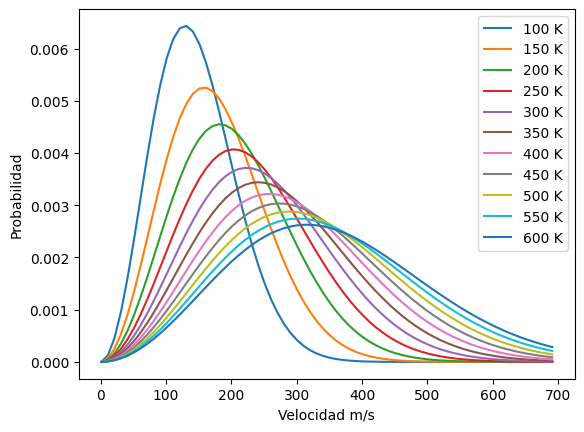

In [845]:
def FuncionProbabilidad(V,T):
    M=0.1
    R=8.31446261815324
    return 4*np.pi*(M/(2*np.pi*R*T))**(3/2)*V**2*np.exp(-(M*V**2)/(2*R*T))
V=np.arange(1,701,10)
T=np.arange(100,650,50)
for i in T:
    P=FuncionProbabilidad(V,i)
    plt.plot(V,P,label=str(i)+" K")
plt.legend()
plt.xlabel('Velocidad m/s')
plt.ylabel('Probabilidad')

A medida que aumenta la temperatura, la velocidad promedio de las moléculas tambien aumenta, incluyendo claramente la velocidad más probable; sin embargo ésta velocidad es cada vez menos probable a comparación con las demás velocidades, es decir la probablidad se va distribuyendo más equitativamente a medida que se aumenta la temperatura del sistema.

In [846]:
raices5 = GetAllRootsGLag(5)
pesos5 = GetWeightsGLag(5)

funcion = lambda u: u
I5 = 0
for i in range(5):
    I5 += pesos5[i]*funcion(raices5[i])

Vi=np.empty(0,dtype=float)
M=0.1
R=8.31446261815324
T=np.arange(100,600,50)
for i in T:
    Vavg=I5*2*np.sqrt((2*R*i)/(np.pi*M))
    Vi=np.append(Vi,Vavg)

In [847]:
Vi

array([145.50809326, 178.21029096, 205.77951892, 230.06849634,
       252.02741044, 272.22071599, 291.01618652, 308.66927838,
       325.3659878 , 341.2467269 ])

Velocidad promedio para 10 Temperaturas distintas, desde 100 K hasta 550 K en saltos de 50 k

[145.50809324 178.21029094 205.77951889 230.06849631 252.0274104
 272.22071595 291.01618647 308.66927834 325.36598775 341.24672685]


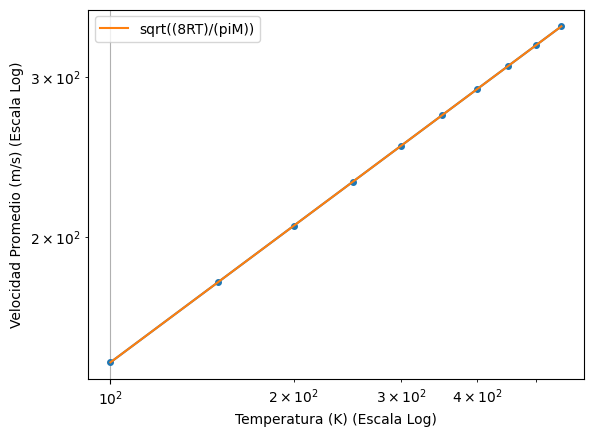

In [848]:
def VelocidadPromedioTeorica (T):
    M=0.1
    R=8.31446261815324
    return np.sqrt((8*R*T)/(np.pi*M))

VelocidadPT=VelocidadPromedioTeorica(T)
print(VelocidadPT)
plt.loglog(T, Vi, marker='o',markersize=4)
plt.loglog(T,VelocidadPT,label="sqrt((8RT)/(piM))")
plt.legend()
plt.xlabel('Temperatura (K) (Escala Log)')
plt.ylabel('Velocidad Promedio (m/s) (Escala Log)')
plt.grid(True)

In [849]:
raices6 = GetAllRootsGLag(5)
pesos6 = GetWeightsGLag(5)

funcion = lambda u: np.power(u,3/2)
I6 = 0
for i in range(5):
    I6 += pesos6[i]*funcion(raices6[i])

Vi=np.empty(0,dtype=float)
M=0.1
R=8.31446261815324
T=np.arange(100,600,50)
for i in T:
    Vrms=(2/np.power(np.pi,1/4))*np.sqrt(((R*i)/M)*I6)
    Vi=np.append(Vi,Vrms)

In [850]:
Vi

array([157.83280557, 193.30491917, 223.20929423, 249.55557756,
       273.37443836, 295.27814143, 315.66561115, 334.81394135,
       352.92488235, 370.15073934])

[157.93475822 193.42978515 223.35347705 249.71677884 273.55102552
 295.46887736 315.86951644 335.03021557 353.15285539 370.38983949]


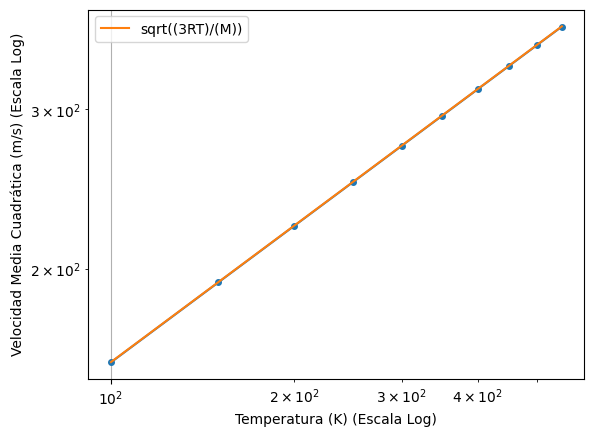

In [851]:
def VelocidadMediaCuadraticaTeorica (T):
    M=0.1
    R=8.31446261815324
    return np.sqrt((3*R*T)/M)

VelocidadMCT=VelocidadMediaCuadraticaTeorica(T)
print(VelocidadMCT)
plt.loglog(T, Vi, marker='o',markersize=4)
plt.loglog(T,VelocidadMCT,label="sqrt((3RT)/(M))")
plt.legend()
plt.xlabel('Temperatura (K) (Escala Log)')
plt.ylabel('Velocidad Media Cuadrática (m/s) (Escala Log)')
plt.grid(True)

